### Import Libraries

In [1]:
from fastai import *
from fastai.vision import *

In [2]:
defaults.device = torch.device('cpu')

### Define Path and Classes

In [3]:
classes = ['crack', 'fine']
for c in classes:
    path = Path('data/road')
    dest = path/c
    dest.mkdir(parents=True, exist_ok=True)

In [4]:
path = os.path.join(os.getcwd(), path)
path

'C:\\Users\\RoniReznik\\fast.ai\\data\\road'

### Download Images

In [8]:
def download_images_from_urls():
    '''Download jpgs from a txt file of urls to an images folder.'''
    
    for c in classes:
        image_location = os.path.join(path, c)
        filename = 'urls_' + c + '.txt'
        url_file_path = os.path.join(image_location, filename)
        download_images(url_file_path, image_location, max_pics=1000)
        print('Files downloaded from: ', c, '\nNumber of files: ', len(os.listdir(image_location)))
        verify_images(image_location, delete=True, max_size=1000)

In [10]:
%%time
download_images_from_urls()

Files downloaded from:  crack 
Number of files:  682


Files downloaded from:  fine 
Number of files:  753


Wall time: 5min 36s


### View Data

In [5]:
np.random.seed(0)

data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, ds_tfms=get_transforms(),
                                 size=224, bs=16).normalize(imagenet_stats)

In [5]:
data.classes

['crack', 'fine']

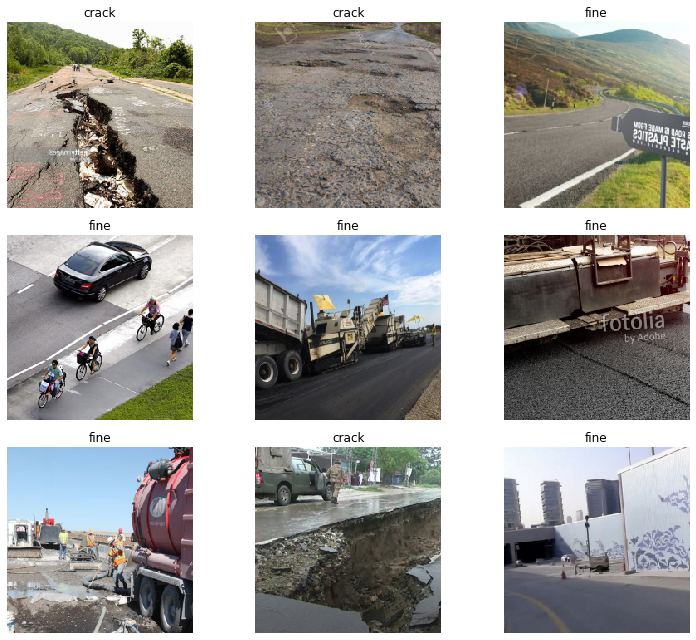

In [19]:
data.show_batch(rows=3, figsize=(11,9))

In [20]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['crack', 'fine'], 2, 1105, 276)

### Train model

In [6]:
learn = cnn_learner(data, models.resnet18, metrics=error_rate)

In [7]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.955453,0.700782,0.231884,06:20
1,0.793850,0.561377,0.224638,07:05
2,0.573946,0.525365,0.210145,06:25
3,0.472910,0.473542,0.173913,06:40


In [8]:
learn.save('stage-1-road')

In [9]:
learn.unfreeze()

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 5.75E-05


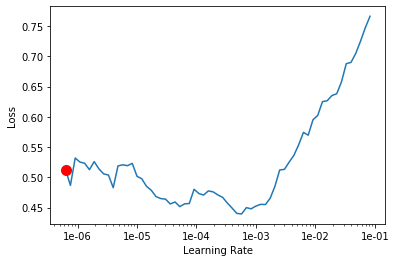

In [15]:
learn.recorder.plot(suggestion=True)

In [16]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.483907,0.482166,0.188406,07:58
1,0.463248,0.437900,0.188406,10:30
2,0.366799,0.448969,0.184783,08:37
3,0.307547,0.443534,0.170290,08:07


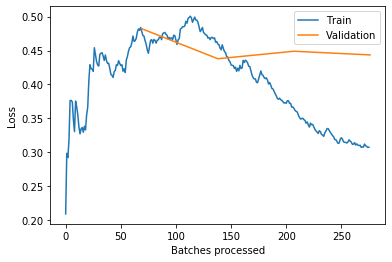

In [17]:
learn.recorder.plot_losses()

### Interpretation

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

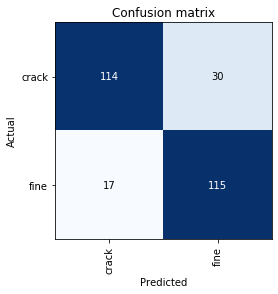

In [19]:
interp.plot_confusion_matrix()

### Cleaning Noisy Images

In [28]:
from fastai.widgets import ImageCleaner, DatasetFormatter

In [29]:
ds, idxs = DatasetFormatter().from_toplosses(learn)

In [30]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [31]:
df = pd.read_csv(path+'\\cleaned.csv', header='infer')

In [32]:
np.random.seed(42)
db = (ImageList.from_df(df, path)
                   .split_none()
                   .label_from_df()
                   .databunch(bs=16))

C:\Users\RoniReznik\Anaconda3\lib\site-packages\fastai\basic_data.py:272: UserWarning: It's not possible to collate samples of your dataset together in a batch.
Shapes of the inputs/targets:
[[torch.Size([3, 800, 1000]), torch.Size([3, 721, 1000]), torch.Size([3, 690, 1000]), torch.Size([3, 748, 500]), torch.Size([3, 666, 1000]), torch.Size([3, 720, 960]), torch.Size([3, 1000, 619]), torch.Size([3, 417, 626]), torch.Size([3, 562, 1000]), torch.Size([3, 427, 850]), torch.Size([3, 607, 1000]), torch.Size([3, 604, 1000]), torch.Size([3, 360, 550]), torch.Size([3, 503, 400]), torch.Size([3, 300, 400]), torch.Size([3, 393, 590])], [(), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ()]]
  warn(message)


You can deactivate this warning by passing `no_check=True`.


In [33]:
learn = cnn_learner(data, models.resnet18, metrics=error_rate)

### The production

In [34]:
defaults.device = torch.device('cpu')

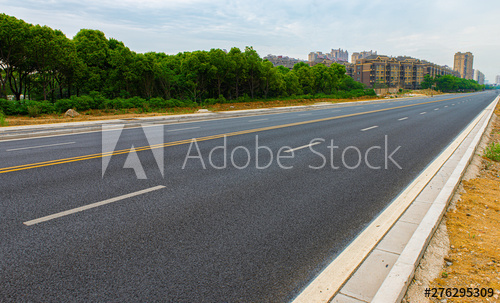

In [36]:
img = open_image(path+'\\fine'+'\\00000000.jpg')
img

In [37]:
classes = ['crack', 'fine'] # define your classes here
data2 = ImageDataBunch.single_from_classes(path, classes, ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)
learn = cnn_learner(data2, models.resnet18)
learn.load('stage-1-road')

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: C:\Users\RoniReznik\fast.ai\data\road;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: C:\Users\RoniReznik\fast.ai\data\road;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [38]:
pred_class, pred_idx, output = learn.predict(img)
pred_class

Category fine